In [2]:
# default_exp cld_steiner

In [127]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
# export cld_steiner


import os
import json
import glob
import subprocess

import cv2
import pcst_fast
import numpy as np
import scipy.spatial

from matplotlib import pyplot as plt
from shapely import geometry as geom

from math import floor, sqrt
from collections import defaultdict

In [4]:
%matplotlib inline

In [5]:
examples = glob.glob('examples/*.png')
examples

['examples/0162681551.png',
 'examples/0168366051.png',
 'examples/0168639352.png']

In [6]:
examples = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in examples]

In [7]:

import PIL.Image
import IPython.display

def show(arr):
    IPython.display.display(PIL.Image.fromarray(arr))

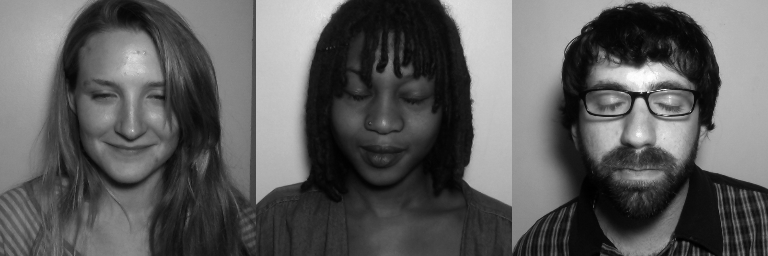

In [8]:
show(np.concatenate(examples, axis=1))

# Raster Edge Extraction
To extract raster edges, look at the "edges.ipynb" notebook. We use a combination of Coherent Line Drawing (CLD) and Canny edge detection.

In [11]:
# export cld_steiner

from blind_contour.edges import raster_edges

In [10]:

from ipywidgets import interact
gray = examples[0]

@interact(histogram_eq=False, cld=True, canny_low=(50, 150), canny_hi=(150, 250))
def _test(histogram_eq, cld, canny_low, canny_hi):
    edges = [raster_edges(ex, histogram_eq, cld, canny_low, canny_hi) for ex in examples]
    return show(np.concatenate(edges, axis=1))

interactive(children=(Checkbox(value=False, description='histogram_eq'), Checkbox(value=True, description='cld…

# Skeletonization

We need to trun those raster edges into lines, where the lines represent the "skeleton" of the edges. We have 3 possible algorithms for this: 

In [36]:
#export cld_steiner

def crop_edge(img):
    # small crop to improve output
    img[:, 240:] = 255
    img[:, :16] = 255
    img[240:, :] = 255
    img[:16, :] = 255
    return img

def vector_trace(img):
    
    cv2.imwrite('trace_in.bmp', edges)
    if os.name == 'nt':
        subprocess.check_call(r'.\potrace-1.16.win64\potrace.exe trace_in.bmp -o trace_out.geojson -b geojson')
    else:
        subprocess.check_call(r'./potrace-1.16.linux-x86_64/potrace trace_in.bmp -o trace_out.geojson -b geojson', shell=True)

    with open('trace_out.geojson') as fp:
        geojson = json.load(fp)

    return [geom.shape(feature["geometry"]) for feature in geojson['features']]

def explode_multilines(lines):
    out = []
    for line in lines:
        if type(line) == geom.multilinestring.MultiLineString:
            out.extend(subline for subline in line)
        else:
            out.append(line)
    return out

Using: Potrace for vector tracing and https://github.com/fitodic/centerline for skeletonization

In [53]:
#export cld_steiner

from centerline.geometry import Centerline 
from shapely import ops

def extract_centerlines(edges):
    ''' Extract centerlines  using Centerline python library '''
    shapes = vector_trace(edges)
    shapes = (shape.buffer(0) for shape in shapes)
    polys = [poly for poly in shapes if type(poly) == geom.Polygon and type(poly.envelope) == geom.Polygon]
    centerlines = [Centerline(p, valid=True) for p in polys]
    
    center_geoms = [line.geoms for line in centerlines]
    center_geom_lines = [geom.MultiLineString(line) for line in center_geoms]
    center_geom_lines = [ops.linemerge(line) for line in center_geom_lines]
    center_geom_lines = explode_multilines(center_geom_lines)

    # prune lines too long/short
    center_geom_lines = [line for line in center_geom_lines 
                         if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    return center_geom_lines

CPU times: user 1.38 s, sys: 15.6 ms, total: 1.39 s
Wall time: 1.42 s


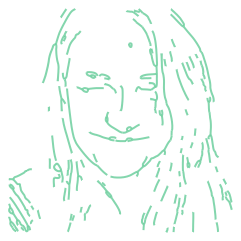

In [54]:
edges = crop_edge(raster_edges(gray))
%time centerlines_from_cl_lib = extract_centerlines(edges)
geom.GeometryCollection(centerlines_from_cl_lib)

Using:

1. scikit-image skeletonization on the raster thick edges
2. [sknw](https://github.com/Image-Py/sknw/tree/master/sknw) for vectorization of the raster skeleton

In [80]:
#export cld_steiner

#!pip install git+https://github.com/Image-Py/sknw
    
from skimage.morphology import skeletonize
import sknw

def extract_centerlines_sknw(edges):
    skel = skeletonize(256 - edges > 128)
    skg = sknw.build_sknw(skel.astype(np.uint16), multi=False, iso=True, ring=False)
    lines = []
    for (s,e) in skg.edges():
        ps = skg[s][e]['pts']
        lines.append(geom.LineString(ps[:, ::-1] * np.array([1, -1]) + np.array([0, 256]) ))
        

    # prune lines too long/short
    lines = [line for line in lines 
             if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    return lines

CPU times: user 31.2 ms, sys: 0 ns, total: 31.2 ms
Wall time: 24.4 ms


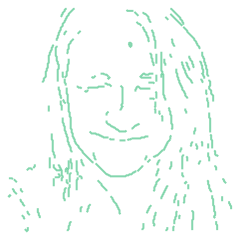

In [84]:
%time geom.GeometryCollection(extract_centerlines_sknw(edges))

Using:

1. Potrace to convert raster edges to (thick) vector edges
2. Convert the potrace extracted edges back to raster
3. scikit-image skeletonization on the raster thick edges
4. [sknw](https://github.com/Image-Py/sknw/tree/master/sknw) for vectorization of the raster skeleton

In [82]:
#export cld_steiner
def extract_centerlines_shapes_sknw(edges):
    shapes = vector_trace(edges)
    
    img = np.zeros((256, 256), dtype=np.uint8)
    
    shapes = (shape.buffer(0) for shape in shapes)
    polys = [poly for poly in shapes if type(poly) == geom.Polygon and type(poly.envelope) == geom.Polygon]
    
    as_contour = [np.array(poly.exterior.coords).astype(np.int32) for poly in polys]
    as_contour = [c[:, np.newaxis, :] for c in as_contour]
    cv2.drawContours(img, as_contour, -1, 255, -1)
    
    skel = skeletonize(img > 128)
    skg = sknw.build_sknw(skel.astype(np.uint16), multi=False, iso=True, ring=False)
    lines = []
    for (s,e) in skg.edges():
        ps = skg[s][e]['pts']
        lines.append(geom.LineString(ps[:, ::-1] ))
        

    # prune lines too long/short
    lines = [line for line in lines 
             if max(line.length, geom.Point(line.coords[0]).distance(geom.Point(line.coords[-1]))) > 4]

    return lines

CPU times: user 31.2 ms, sys: 31.2 ms, total: 62.5 ms
Wall time: 84.1 ms


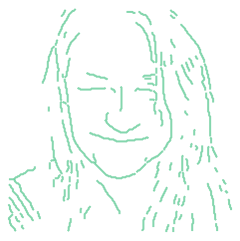

In [83]:
%time geom.GeometryCollection(extract_centerlines_shapes_sknw(edges))

In [73]:
#export cld_steiner

import time 

def image_to_lines(gray, centerline_extractor=extract_centerlines_shapes_sknw):
    t0 = time.time()
    
    edges = crop_edge(raster_edges(gray))
        
    print(f'raster edges\t{time.time() - t0:.2f}s')
    t1 = time.time()
    
    center_geom_lines = centerline_extractor(edges)

    print(f'skeletonization\t{time.time() - t1:.2f}s')
    return center_geom_lines

In [86]:
@interact(centerline_extractor=['potrace + opencv + sknw', 'potrace + Centerline (pypi)', 'opencv + sknw'])
def _test_il(centerline_extractor):
    if centerline_extractor == 'potrace + Centerline (pypi)':
        centerline_extractor = extract_centerlines
    elif centerline_extractor == 'opencv + sknw':
        centerline_extractor = extract_centerlines_sknw
    elif centerline_extractor == 'potrace + opencv + sknw':
        centerline_extractor = extract_centerlines_shapes_sknw
    print(centerline_extractor)
    return geom.GeometryCollection(image_to_lines(gray, centerline_extractor=centerline_extractor))

interactive(children=(Dropdown(description='centerline_extractor', options=('potrace + opencv + sknw', 'potrac…

In [102]:
# export cld_steiner

def reorder_start_dist(lines):
    bounds = geom.MultiLineString(lines).bounds
    center = geom.Point((bounds[2] - bounds[0])/2, (bounds[3] - bounds[1])/2)
    def dist(line):
        return center.distance(geom.Point(line.coords[0]))
    return sorted(lines, key=dist)


In [90]:
# export cld_steiner

def sobel(gray):
    scale = 1
    delta = 0
    ddepth = cv2.CV_32FC1

    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    # Gradient-Y
    # grad_y = cv.Scharr(gray,ddepth,0,1)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    
    
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

In [94]:
# export cld_steiner

def sample_grad(grad_blurred):
    gp = grad_blurred.copy()
    gp[gp < (gp.mean() + 0.5 * gp.std())] = 0.0
    prob = gp
    sample_at = (np.random.poisson(prob + 0.001, (256, 256)) > 0).astype(np.uint8)
    
    sampled_grad_pixels = grad_blurred * sample_at
    sampled_grad_pixels[0, 0] = 1
    sampled_grad_pixels[-1, -1] = 1
    sampled_grad_pixels[0, -1] = 1
    sampled_grad_pixels[-1, 0] = 1
    
    return sampled_grad_pixels


In [96]:
# export cld_steiner

def triangulate(sampled_grad_pixels):
    nonzero_ys, nonzero_xs = np.nonzero(sampled_grad_pixels)
    nonzero_coords = np.dstack((nonzero_xs, 255 - nonzero_ys)).squeeze().astype(np.float32)
    tri = scipy.spatial.Delaunay(nonzero_coords)
    
    z = np.zeros_like(sampled_grad_pixels)
    p = tri.points.astype(np.int)
    vals = np.nonzero(sampled_grad_pixels)
    z[p[:, 1], p[:, 0]] = sampled_grad_pixels[vals[0], vals[1]]
    return tri, z
    

In [99]:
# export cld_steiner

def to_graph(tri):
    ''' Convert scipy Triangulation to a graph (dict representation) '''
    nbrs = {i:set() for i in range(len(tri.points))}

    for smplx in tri.simplices:
        nbrs[smplx[0]].add(smplx[1])
        nbrs[smplx[1]].add(smplx[2])
        nbrs[smplx[2]].add(smplx[0])

        nbrs[smplx[1]].add(smplx[0])
        nbrs[smplx[2]].add(smplx[1])
        nbrs[smplx[0]].add(smplx[2])
    
    return nbrs

In [105]:
# export cld_steiner

def nearest_vertex(tri, pt):
    curr_smplx_idx = tri.find_simplex(pt)
    curr_smplx = tri.simplices[curr_smplx_idx]
    nearest_smplx_corner_to_curr = min(curr_smplx, key=lambda idx: pt_vert_distance(pt, tri, idx))            
    return nearest_smplx_corner_to_curr

In [114]:
# export cld_steiner

def merge_naive(lines):
    all_coords = [list(line.coords) for line in lines]
    flattened = [coord for coords in all_coords for coord in coords]
    return geom.LineString(flattened)

def pt_vert_distance(pt, tri, idx):
    return sqrt(tuple_sq_dist(pt, tri.points[idx]))

def nearest_line(pt, lines, remaining_line_idxs):
    nearest = None
    nearest_idx = None
    flip = False
    closest_dist = 1e10
    for idx in remaining_line_idxs:
        other = lines[idx]
        start_dist = tuple_sq_dist(pt, other.coords[0])
        end_dist = tuple_sq_dist(pt, other.coords[-1])
        if start_dist < closest_dist:
            flip = False
            closest_dist = start_dist
            nearest = other
            nearest_idx = idx
        elif end_dist < closest_dist:
            flip = True
            closest_dist = end_dist
            nearest = other
            nearest_idx = idx
    return nearest, nearest_idx, flip


def mk_heuristic_fn(tri, grad_blurred):
    
    grad_max = grad_blurred.max()

    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    def heuristic(i, goal):
        dist = distance(i, goal)
        coords = tri.points[i].astype(np.int)
        edginess = grad_blurred[255 - coords[1], coords[0]]
        return dist + (1.0 - edginess) * 10
    return heuristic

def mk_weight_fn(tri, grad_blurred):
    def distance(i, j):
        i_pos = tri.points[i]
        j_pos = tri.points[j]
        dx = i_pos - j_pos
        return np.linalg.norm(dx)

    grad_max = grad_blurred.max()

    def weight(i, j):
        dist = distance(i, j) ** 1.5
        i_pos = tri.points[i]
        j_pos = tri.points[j]

        mid = (i_pos + j_pos).astype(np.int) // 2
        i_pos = i_pos.astype(np.int)
        j_pos = j_pos.astype(np.int)
        edginess = (grad_blurred[255 - mid[1], mid[0]] +
                    grad_blurred[255 - i_pos[1], i_pos[0]] + 
                    grad_blurred[255 - j_pos[1], j_pos[0]])/3.0
        return dist + (1.0 - edginess)*10
    return weight

def tuple_sq_dist(a, b):
    dx = a[0] - b[0]
    dy = a[1] - b[1]
    return (dx*dx) + (dy*dy)

In [123]:
# export cld_steiner

def traverse(graph, curr, seen, tri, special, lines):
    seen.add(curr)
    nbrs = graph[curr]
    yield tri.points[curr]
    for nbr in nbrs:
        if nbr in seen:
            continue 
        
        if (curr, nbr) in special:
            line_idx, reverse = special[(curr, nbr)]
            yield from lines[line_idx].coords[::-1 if reverse else 1]
            
        yield from traverse(graph, nbr, seen, tri, special, lines)
        
        if len(seen) < len(graph):
            if (curr, nbr) in special:
                line_idx, reverse = special[(curr, nbr)]
                yield from lines[line_idx].coords[::1 if reverse else -1]

    if len(seen) < len(graph):
        yield tri.points[curr]


In [124]:
# export cld_steiner

def rgb2line_steiner(img):
    rgb = np.asarray(img)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    line = pipeline_steiner(gray)
    return line.__geo_interface__

def pipeline_steiner(gray):
    
    center_geom_lines = image_to_lines(gray)
    
    grad = sobel(gray)

    grad_blurred = cv2.GaussianBlur(grad / grad.max(), (9, 9), 5.0)

    grad_samples = sample_grad(grad_blurred)

    for line in center_geom_lines:
        s = line.coords[0]
        e = line.coords[-1]
        grad_samples[floor(s[0]), floor(s[1])] = 1
        grad_samples[floor(e[0]), floor(e[1])] = 1

    tri, grad_samples = triangulate(grad_samples)

    tri_graph = to_graph(tri)

    center_geom_lines = reorder_start_dist(center_geom_lines)
    
    data = []
    ss = []
    ts = []

    def w(i, j):
        start = tri.points[i]
        end = tri.points[j]
        mid = np.floor((start + end) / 2).astype(np.int)
        gf = 1.0 - grad_blurred[255 - mid[1], mid[0]]
        dist = np.linalg.norm(start - end)
        return dist + gf * 10.0

    for s, nbrs in tri_graph.items():
        for t in nbrs:
            ss.append(s)
            ts.append(t)
            data.append(w(s, t))
            
    mat = scipy.sparse.coo_matrix((data, (ss, ts))).tocsc()
    
    tri_verts = [(nearest_vertex(tri, line.coords[0]), nearest_vertex(tri, line.coords[-1])) for line in center_geom_lines]

    starts = np.asarray([v[0] for v in tri_verts])
    ends = np.asarray([v[1] for v in tri_verts])

    tri_mat = mat.copy()
    tri_mat[starts, ends] = 0.00001234 #     
    tri_mat[ends, starts] = 0.00001234 #     
    flat_edges_i, flat_edges_j = tri_mat.nonzero()
    flat_edges = np.dstack((flat_edges_i, flat_edges_j)).squeeze().astype(np.int64)
    
    prizes = np.zeros(shape=(tri_mat.shape[0],), dtype=np.float64)
    
    prizes[starts] = 100
    prizes[ends] = 100
    
    costs = np.asarray(tri_mat[flat_edges_i, flat_edges_j].squeeze()).squeeze()
    flat_edges.shape, prizes.shape
    t1 = time.time()
    v, es = pcst_fast.pcst_fast(flat_edges, prizes, costs, -1, 1, 'gw', 1)
    print('pcst:', time.time() - t1)
    lines = center_geom_lines[:]
    
    graph = defaultdict(list)
    for e in es:
        st, end = flat_edges[e]
        graph[st].append(end)
        graph[end].append(st)


    special = {}
    for i, (s, e) in enumerate(zip(starts, ends)):
        special[(s, e)] = i, False
        special[(e, s)] = i, True

    return geom.LineString(traverse(graph, starts[0], set(), tri, special, lines))

raster edges	0.51s
skeletonization	0.09s
Finished GW clustering: final event time 2.462205e+01, number of edge events 23347

pcst: 0.017961740493774414
CPU times: user 1.27 s, sys: 953 ms, total: 2.22 s
Wall time: 967 ms


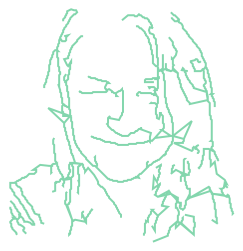

In [126]:
%time res0 = pipeline_steiner(examples[0])
res0